## imports

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.fft import rfft, rfftfreq
from scipy.signal import butter, filtfilt, find_peaks, get_window
import matplotlib.pyplot as plt
from IPython.display import display
from ipywidgets import interact, FloatSlider, IntSlider, Layout, Output

In [2]:
DEFAULT_PARAMS = {
    'oxygen_ex': 1.1, 
    'lactate_ex': 0.1,
    'k_HIF_production_basal': 0.02, 
    'k_HIF_production_max': 0.9, 
    'k_HIF_pos_feedback': 1,
    'k_HIF_deg_basal': 0.2, 
    'k_HIF_deg_lactate': 1, 
    'k_lactate_production': 0.01,
    'k_lactate_production_reg': 1, 
    'k_lactate_deg_basal': 0.01,
    'k_GFP_production_constantFP_production': 1, 
    'k_GFP_production_constant': 0.05,
    'k_GFP_deg': 0.1, 
    'k_MCT1': 1E-3, 
    'k_MCT4': 1E-3, 
    'o2_response_scaling': 1.0,
    'kmax_o2_deg': 1e-1, 
    'k_min_o2_deg': 1e-2, 
    'conc_conversion_oxygen': 1.0,
    'conc_conversion_lactate': 1.0
}


In [3]:
def system_of_odes(
    y, t, 
    oxygen_ex=1.1, 
    lactate_ex=0.1,
    k_HIF_production_basal=0.02, 
    k_HIF_production_max=0.9, 
    k_HIF_pos_feedback=1,
    k_HIF_deg_basal=0.2, 
    k_HIF_deg_lactate=1, 
    k_lactate_production=0.01,
    k_lactate_production_reg=1, 
    k_lactate_deg_basal=0.01,
    k_GFP_production_constantFP_production=1, 
    k_GFP_production_constant=0.05,
    k_GFP_deg=0.1, 
    k_MCT1=1E-3, 
    k_MCT4=1E-3, 
    o2_response_scaling=1.0,
    kmax_o2_deg=1e-1, 
    k_min_o2_deg=1e-2, 
    conc_conversion_oxygen=1.0,
    conc_conversion_lactate=1.0
):
    # Unpack variables
    hif_in, lactate_in, gfp_in = y
    
    # System equations
    hif_production = (k_HIF_production_basal + 
                      k_HIF_production_max * hif_in ** 2 / 
                      (k_HIF_pos_feedback + hif_in ** 2))
    hif_degradation = (k_HIF_deg_basal * hif_in * oxygen_ex + 
                       k_HIF_deg_lactate * hif_in * lactate_in)
    dHIF = hif_production - hif_degradation
    
    lactate_production = (k_lactate_production * hif_in ** 2 / 
                          (k_lactate_production_reg + hif_in ** 2))
    lactate_degradation = k_lactate_deg_basal * lactate_in
    lactate_transport = k_MCT1 * lactate_ex - k_MCT4 * lactate_in
    dLactate = lactate_production - lactate_degradation + lactate_transport

    # lactate_total_produced = (lactate_production - lactate_degradation) - lac_0
    
    gfp_production = (k_GFP_production_constantFP_production * hif_in ** 3 / 
                      (k_GFP_production_constant + hif_in ** 3))
    gfp_degradation = k_GFP_deg * gfp_in
    dGFP = gfp_production - gfp_degradation
    
    dO2_ext = 0
    if oxygen_ex > 0:
        dO2_ext = -o2_response_scaling * (k_min_o2_deg + kmax_o2_deg / (hif_in + 1))
    
    # Convert from concentration to counts (or vice versa)
    dO2_ext *= conc_conversion_oxygen
    dLactate_ext = -lactate_transport * conc_conversion_lactate
    
    return [
        dHIF, 
        dLactate, 
        dGFP, 
    ]

In [4]:
def plot_ode_solution(t, solution, lactate_production_rates=None, lactate_degradation_rates=None):
    # Unpack the solution
    hif_in, lactate_in, gfp_in = solution.T  # Transpose to unpack by columns

    # Create the plots
    n_plots = 3
    if lactate_production_rates is not None:
        n_plots +=1
    if lactate_degradation_rates is not None:
        n_plots +=1
    fig, axs = plt.subplots(n_plots, 1, figsize=(6, 4), sharex=True)  # Set up subplots with shared x-axis

    # Plot HIF
    axs[0].plot(t, hif_in, label='HIF')
    axs[0].set_ylabel('HIF\nconc')
    # axs[0].legend()

    # Remove x-ticks for the first two plots
    axs[0].tick_params(labelbottom=False)  # Hide x-ticks for the first plot

    # Plot internal Lactate
    axs[1].plot(t, lactate_in, label='Lactate (internal)')
    axs[1].set_ylabel('Lac\nconc')
    # axs[1].legend()
    axs[1].tick_params(labelbottom=False)  # Hide x-ticks for the second plot

    # Plot GFP
    axs[2].plot(t, gfp_in, label='GFP')
    # axs[2].set_xlabel('Time')  # Only this plot will show the x-axis label
    axs[2].set_ylabel('GFP\nconc')
    # axs[2].legend()

    # Plot lactate production and degradation rates
    if lactate_production_rates is not None:
        axs[3].plot(t, lactate_production_rates, label='Lactate Production Rate')
        axs[3].set_ylabel('Lac\nProd\nRate')
        # axs[3].legend()
    if lactate_degradation_rates is not None:
        axs[4].plot(t, lactate_degradation_rates, label='Lactate Degradation Rate')
        axs[4].set_ylabel('Lac\nDeg\nRate')
        # axs[4].legend()

    # time on the bottom axis
    axs[n_plots-1].set_xlabel('Time')  # Only this plot will show the x-axis label


    plt.tight_layout()  # Adjust the layout to make room for all the plots
    plt.show()

### detect oscillation period function

In [5]:
def detect_oscillation_period(
    signal, 
    timesteps, 
    window_fraction=0.5, 
    threshold_fraction=0.1,
    overlap_fraction=0.25
):
    # Calculate actual sampling intervals
    sampling_intervals = np.diff(timesteps)
    average_sampling_interval = np.mean(sampling_intervals)

    # Constants and window setup
    window_size = int(len(signal) * window_fraction)
    step_size = int(window_size * (1 - overlap_fraction))
    window_function = get_window('hann', window_size)
    periods = []

    # Iterate over each window segment of the signal
    for start_index in range(0, len(signal) - window_size + 1, step_size):
        # Apply window function to the segment
        windowed_signal = signal[start_index:start_index + window_size] * window_function
        # Perform FFT
        windowed_fft = rfft(windowed_signal)
        freqs = rfftfreq(window_size, d=average_sampling_interval)
        magnitude = np.abs(windowed_fft)
        
        # Detect peaks and find the dominant frequency
        peak_threshold = np.max(magnitude) * threshold_fraction
        peaks, _ = find_peaks(magnitude, height=peak_threshold)
        if peaks.size > 0:
            dominant_peak = peaks[np.argmax(magnitude[peaks])]
            dominant_freq = freqs[dominant_peak]
            if dominant_freq > 0:
                period = 1 / dominant_freq
                periods.append(period)
    
    # Calculate the average period if any periods were detected
    if periods:
        return np.mean(periods)
    else:
        return None

# def detect_oscillation_period(
#     signal, 
#     sampling_rate=0.1, 
#     window_fraction=0.5, 
#     threshold_fraction=0.1,
#     overlap_fraction=0.25
# ):
#     # Constants and window setup
#     window_size = int(len(signal) * window_fraction)
#     step_size = int(window_size * (1 - overlap_fraction))
#     window_function = get_window('hann', window_size)
#     periods = []

#     # Iterate over each window segment of the signal
#     for start_index in range(0, len(signal) - window_size + 1, step_size):
#         # Apply window function to the segment
#         windowed_signal = signal[start_index:start_index + window_size] * window_function
#         # Perform FFT
#         windowed_fft = rfft(windowed_signal)
#         freqs = rfftfreq(window_size, d=1. / sampling_rate)
#         magnitude = np.abs(windowed_fft)
        
#         # Detect peaks and find the dominant frequency
#         peak_threshold = np.max(magnitude) * threshold_fraction
#         peaks, _ = find_peaks(magnitude, height=peak_threshold)
#         if peaks.size > 0:
#             dominant_peak = peaks[np.argmax(magnitude[peaks])]
#             dominant_freq = freqs[dominant_peak]
#             if dominant_freq > 0:
#                 period = 1 / dominant_freq
#                 periods.append(period)
    
#     # Calculate the average period if any periods were detected
#     if periods:
#         return np.mean(periods)
#     else:
#         return None


def plot_phase_diagram(param1_name, param1_range, param2_name, param2_range, total_time=1000, resolution=50):
    param1_values = np.linspace(*param1_range, resolution)
    param2_values = np.linspace(*param2_range, resolution)
    period_matrix = np.zeros((resolution, resolution))
    params = DEFAULT_PARAMS.copy()

    for i, param1 in enumerate(param1_values):
        for j, param2 in enumerate(param2_values):
            # Setup initial conditions and time array
            y0 = [0.1, 0.001, 0.0]
            t = np.linspace(0, total_time, int(total_time))
            
            # Update the two parameters we're varying
            params[param1_name] = param1
            params[param2_name] = param2

            # Solve ODE
            solution = odeint(system_of_odes, y0, t, args=tuple(params.values()))

            # Detect oscillation period
            signal = solution[:, 0]  # Assuming we're interested in the HIF component for oscillation detection
            period = detect_oscillation_period(signal, t)
            
            # Store the period in the matrix
            period_matrix[i, j] = period if period is not None else 0

    # Plotting the phase diagram
    plt.figure(figsize=(10, 8))
    plt.imshow(period_matrix, origin='lower', extent=[*param1_range, *param2_range], aspect='auto')
    plt.colorbar(label='Oscillation Period')
    plt.xlabel(param1_name)
    plt.ylabel(param2_name)
    plt.title('Phase Diagram of Oscillation Periods')
    plt.show()

In [6]:
# initial conditions
y0 = [0.1, 0.001, 0.0]  # Initial conditions for HIF, lactate_in, GFP, oxygen_ex, lactate_ex

# time vector
total_time = 5000
time_points = 1001
t = np.linspace(0, total_time, time_points)

# Conc conversion factors
conc_conversion_oxygen = 1.0
conc_conversion_lactate = 1.0

# external state
oxygen_ex=1.1 
lactate_ex=0.1

# Solve the ODEs
solution = odeint(system_of_odes, y0, t, args=(oxygen_ex, lactate_ex))

# Recalculate lactate production and degradation
lactate_production_rates = DEFAULT_PARAMS['k_lactate_production'] * (solution[:, 0] ** 2) / (DEFAULT_PARAMS['k_lactate_production_reg'] + solution[:, 0] ** 2)
lactate_degradation_rates = DEFAULT_PARAMS['k_lactate_deg_basal'] * solution[:, 1]

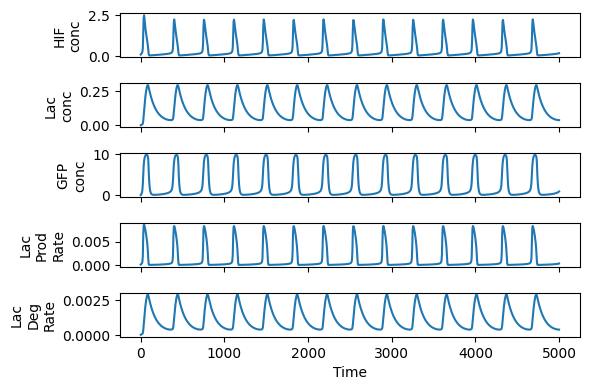

In [7]:
# plot_ode_solution(t, solution)
# Plot the results (assuming the plot_ode_solution function takes the solution and plots it)
plot_ode_solution(t, solution, lactate_production_rates, lactate_degradation_rates)

### plot_ode_solution_with_parameters

In [8]:
def plot_ode_solution_with_parameters(
    oxygen_ex, 
    lactate_ex,
    k_HIF_production_basal, 
    k_HIF_production_max, 
    k_HIF_pos_feedback,
    k_HIF_deg_basal, 
    k_HIF_deg_lactate, 
    k_lactate_production,
    k_lactate_production_reg, 
    k_lactate_deg_basal,
    k_GFP_production_constantFP_production, 
    k_GFP_production_constant,
    k_GFP_deg, 
    k_MCT1, 
    k_MCT4, 
    o2_response_scaling,
    kmax_o2_deg, 
    k_min_o2_deg, 
    total_time=5000
):
    conc_conversion_oxygen = 1
    conc_conversion_lactate = 1
    
    # Define initial conditions and time array based on total_time
    y0 = [0.1, 0.001, 0.0]  # Example initial conditions
    t = np.linspace(0, total_time, int(total_time))  # Time array

    # Solve the ODE system with the current parameters
    solution = odeint(system_of_odes, y0, t, args=(
        oxygen_ex, lactate_ex,
        k_HIF_production_basal, k_HIF_production_max, k_HIF_pos_feedback,
        k_HIF_deg_basal, k_HIF_deg_lactate, k_lactate_production,
        k_lactate_production_reg, k_lactate_deg_basal,
        k_GFP_production_constantFP_production, k_GFP_production_constant,
        k_GFP_deg, k_MCT1, k_MCT4, o2_response_scaling,
        kmax_o2_deg, k_min_o2_deg, conc_conversion_oxygen,
        conc_conversion_lactate
    ))

    # Recalculate lactate production and degradation
    lactate_production_rates = k_lactate_production * (solution[:, 0] ** 2) / (k_lactate_production_reg + solution[:, 0] ** 2)
    lactate_degradation_rates = k_lactate_deg_basal * solution[:, 1]
    
    # Plot the results (assuming the plot_ode_solution function takes the solution and plots it)
    plot_ode_solution(t, solution, lactate_production_rates, lactate_degradation_rates)


    print(f"Osc period {detect_oscillation_period(solution[:,0], t)}")
    # plt.show()

In [9]:
# Custom layout for the sliders
slider_layout = Layout(width='500px', height='10px')
label_layout = Layout(width='250px')

# Function to create a FloatSlider with custom layout
def custom_float_slider(description, min, max, step, value):
    return FloatSlider(
        value=value,
        min=min,
        max=max,
        step=step,
        description=description,
        style={'description_width': 'initial'},  # This ensures the description text is not cut off
        layout=slider_layout,
        readout_format='.6f',
        tooltip=description  # Adds a tooltip showing the full description
    )

### interact

In [10]:
interact(plot_ode_solution_with_parameters,
         oxygen_ex=custom_float_slider('oxygen_ex', 0.0, 2.0, 0.001, 1.1),
         lactate_ex=custom_float_slider('lactate_ex', 0.0, 2.0, 0.001, 0.1),
         k_HIF_production_basal=custom_float_slider('k_HIF_prod_basal', 0.0, 0.1, 0.001, 0.02),
         k_HIF_production_max=custom_float_slider('k_HIF_production_max', 0.0, 2.0, 0.01, 0.9),
         k_HIF_pos_feedback=custom_float_slider('k_HIF_pos_feedback', 0.0, 10.0, 0.1, 1),
         k_HIF_deg_basal=custom_float_slider('k_HIF_deg_basal', 0.0, 1.0, 0.01, 0.2),
         k_HIF_deg_lactate=custom_float_slider('k_HIF_deg_lactate', 0.0, 2.0, 0.01, 1),
         k_lactate_production=custom_float_slider('k_lactate_production', 0.0, 0.05, 0.001, 0.011),
         k_lactate_production_reg=custom_float_slider('k_lactate_production_reg', 0.0, 2.0, 0.1, 1),
         k_lactate_deg_basal=custom_float_slider('k_lactate_deg_basal', 0.0, 0.1, 0.001, 0.01),
         k_GFP_production_constantFP_production=custom_float_slider('k_GFP_production_constantFP_production', 0.0, 2.0, 0.01, 1),
         k_GFP_production_constant=custom_float_slider('k_GFP_production_constant', 0.0, 0.1, 0.001, 0.05),
         k_GFP_deg=custom_float_slider('k_GFP_deg', 0.0, 0.5, 0.01, 0.1),
         k_MCT1=custom_float_slider('k_MCT1', 0.0, 0.01, 1E-4, 1E-3),
         k_MCT4=custom_float_slider('k_MCT4', 0.0, 0.01, 1E-4, 1E-3),
         o2_response_scaling=custom_float_slider('o2_response_scaling', 0.0, 2.0, 0.1, 1.0),
         kmax_o2_deg=custom_float_slider('kmax_o2_deg', 0.0, 0.5, 0.01, 1e-1),
         k_min_o2_deg=custom_float_slider('k_min_o2_deg', 0.0, 0.1, 0.001, 1e-2),
         total_time=custom_float_slider('Total Time', 10, 10000, 10, 2000)
        )

interactive(children=(FloatSlider(value=1.1, description='oxygen_ex', layout=Layout(height='10px', width='500p…

<function __main__.plot_ode_solution_with_parameters(oxygen_ex, lactate_ex, k_HIF_production_basal, k_HIF_production_max, k_HIF_pos_feedback, k_HIF_deg_basal, k_HIF_deg_lactate, k_lactate_production, k_lactate_production_reg, k_lactate_deg_basal, k_GFP_production_constantFP_production, k_GFP_production_constant, k_GFP_deg, k_MCT1, k_MCT4, o2_response_scaling, kmax_o2_deg, k_min_o2_deg, total_time=5000)>

## 2D parameter phase diagram

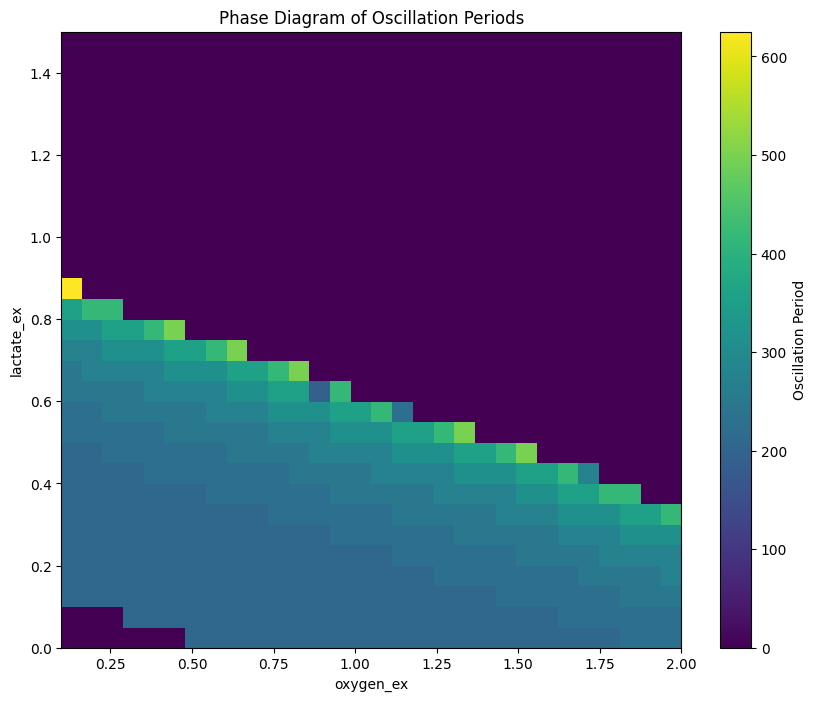

In [11]:
# Define the parameter ranges
oxygen_ex_range = (0.1, 2.0)  # From 0.1 to 2.0
lactate_ex_range = (0.0, 1.5)  # From 0.0 to 2.0

# Define the total time for simulation and resolution of the scan
total_time = 5000  # Total time to simulate the ODEs
resolution = 30   # Number of points to evaluate in each parameter range

# Call the function to plot the phase diagram
plot_phase_diagram(
    param1_name='oxygen_ex', 
    param1_range=oxygen_ex_range, 
    param2_name='lactate_ex', 
    param2_range=lactate_ex_range, 
    total_time=total_time, 
    resolution=resolution
)

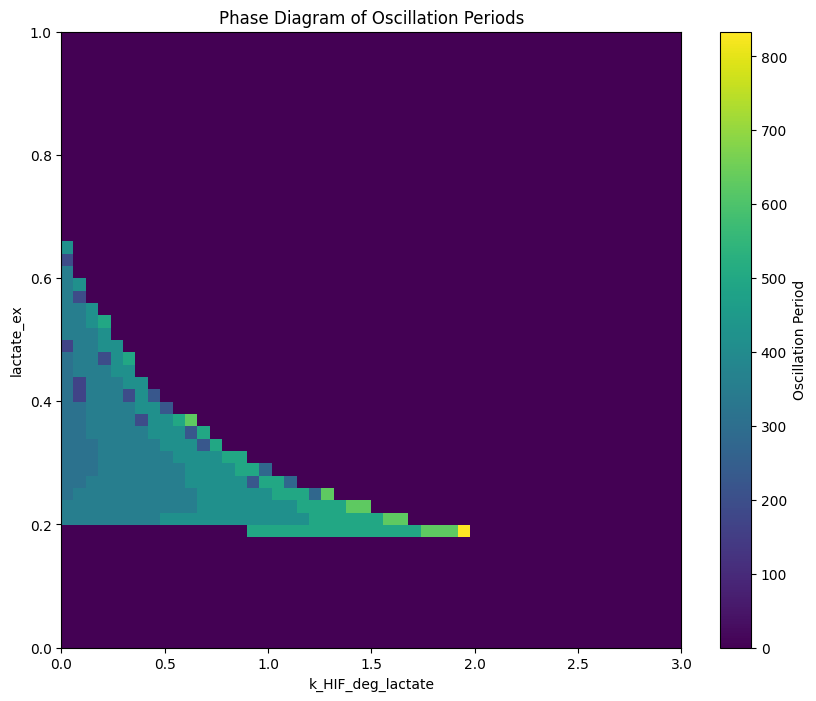

In [12]:
# Define the parameter ranges
k_HIF_deg_lactate_range = (0.0, 3.0)  # From 0.1 to 2.0
lactate_ex_range = (0.0, 1.0)  # From 0.0 to 2.0

# Define the total time for simulation and resolution of the scan
total_time = 5000  # Total time to simulate the ODEs
resolution = 50   # Number of points to evaluate in each parameter range

# Call the function to plot the phase diagram
plot_phase_diagram(
    param1_name='k_HIF_deg_lactate', 
    param1_range=k_HIF_deg_lactate_range, 
    param2_name='lactate_ex', 
    param2_range=lactate_ex_range, 
    total_time=total_time, 
    resolution=resolution
)

## 3D parameter phase diagram

In [13]:
def plot_3d_phase_diagram(
    param1_name, param1_range, 
    param2_name, param2_range,
    param3_name, param3_range,
    total_time=1000, resolution=20, slice_count=5):
    
    param1_values = np.linspace(*param1_range, resolution)
    param2_values = np.linspace(*param2_range, resolution)
    param3_values = np.linspace(*param3_range, slice_count)

    for k, param3 in enumerate(param3_values):
        period_matrix = np.zeros((resolution, resolution))

        for i, param1 in enumerate(param1_values):
            for j, param2 in enumerate(param2_values):
                # Set initial conditions and time array
                y0 = [0.1, 0.001, 0.0]
                t = np.linspace(0, total_time, int(total_time))
                
                # Define parameters with the third parameter fixed
                params = DEFAULT_PARAMS.copy()

                # Update parameters for the current combination
                params[param1_name] = param1
                params[param2_name] = param2
                params[param3_name] = param3

                # Solve the ODE
                solution = odeint(system_of_odes, y0, t, args=tuple(params.values()))

                # Detect oscillation period from HIF component
                signal = solution[:, 0]  # Assuming we're looking at the first component for oscillations
                period = detect_oscillation_period(signal, t)
                
                # Store the period in the matrix
                period_matrix[i, j] = period if period is not None else 0

        # Plot the results for the current slice
        plt.figure(figsize=(10, 8))
        plt.imshow(period_matrix, origin='lower', extent=[*param1_range, *param2_range], aspect='auto')
        plt.colorbar(label='Oscillation Period')
        plt.xlabel(param1_name)
        plt.ylabel(param2_name)
        plt.title(f'Phase Diagram of Oscillation Periods ({param3_name}={param3:.2f})')
        plt.show()


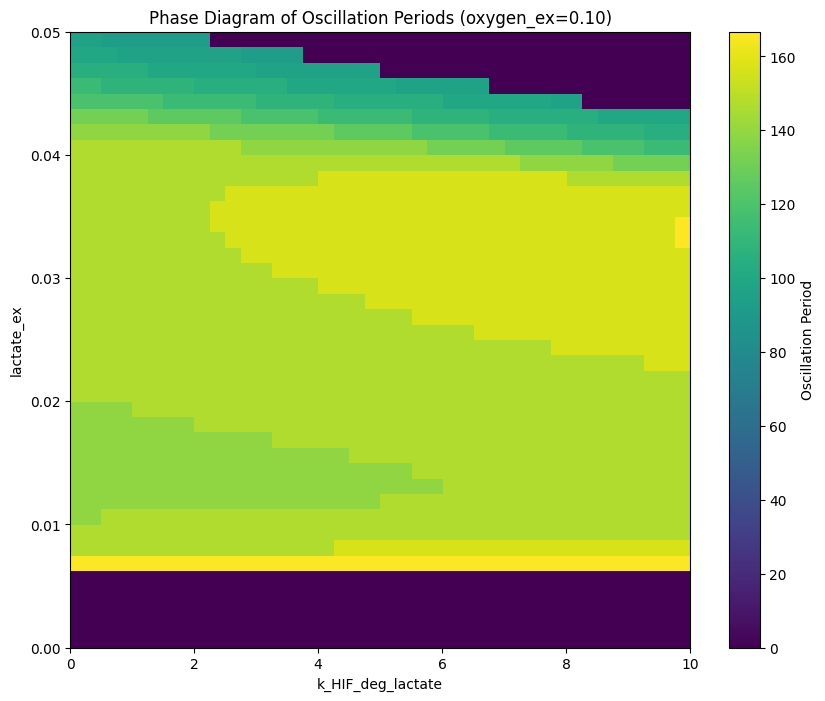

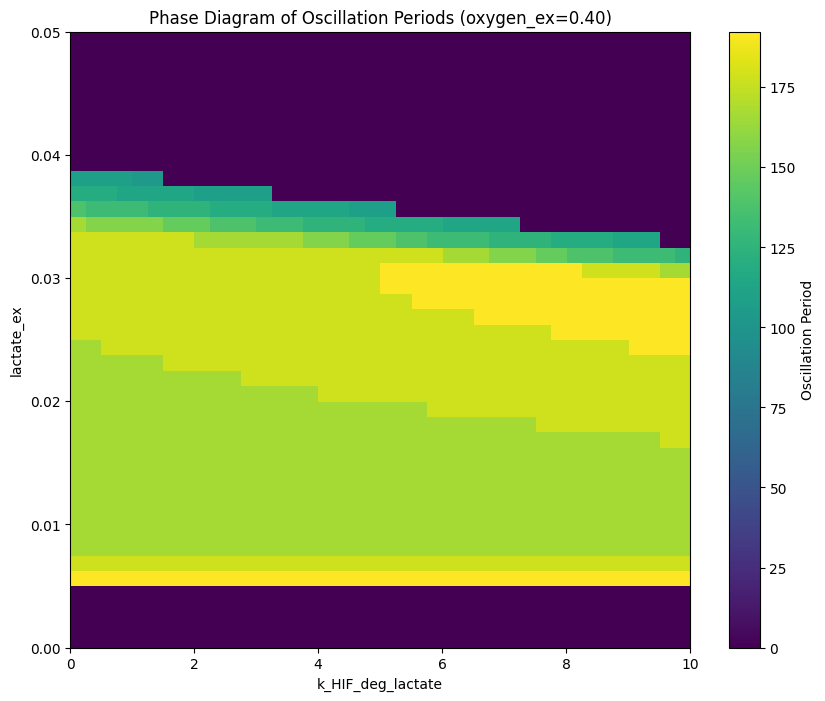

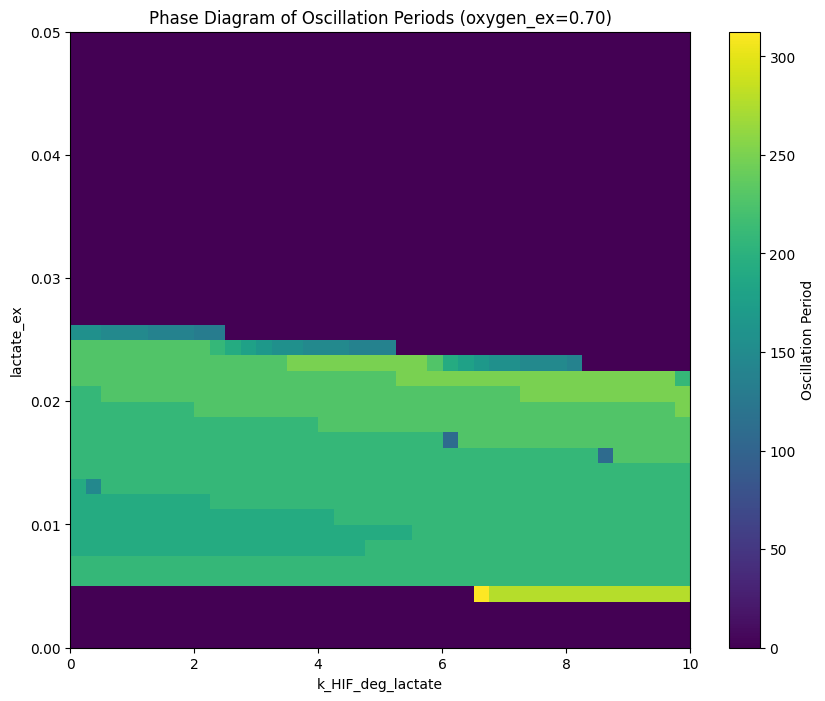

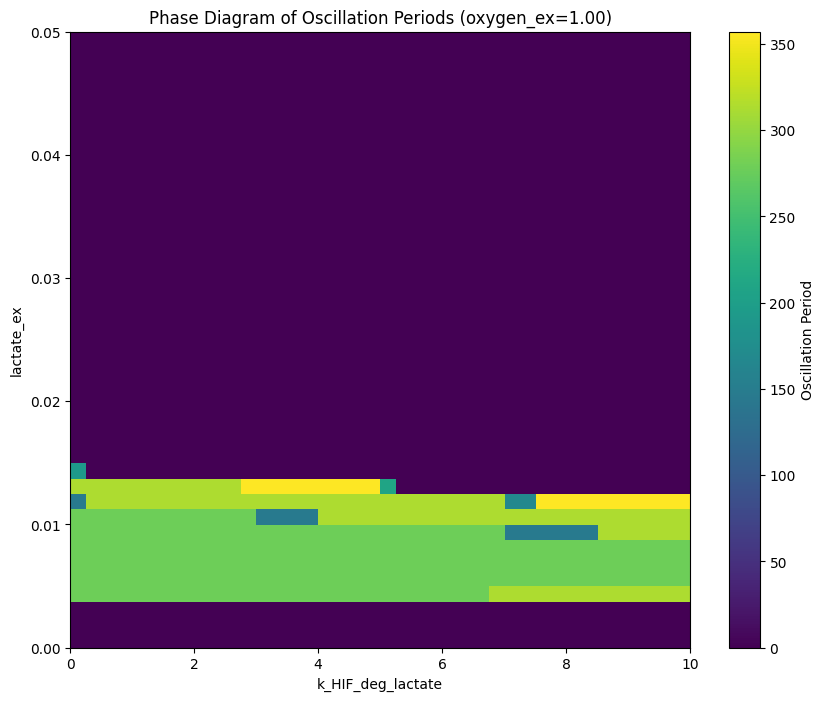

In [14]:
# Define the parameter ranges
oxygen_ex_range = (0.1, 1.0)  # From 0.1 to 2.0 for oxygen_ex
lactate_ex_range = (0.0, 0.05)  # From 0.0 to 2.0 for lactate_ex
k_HIF_deg_lactate_range = (0.0, 10.0)  # From 0.1 to 2.0 for k_HIF_deg_lactate

# Define the total time for simulation and resolution of the scan
# total_time = 5000  # Total time to simulate the ODEs
resolution = 40   # Number of points to evaluate in each parameter range
slice_count = 4   # Number of slices for the third parameter

# Call the function to plot the phase diagram
plot_3d_phase_diagram(
    param3_name='oxygen_ex', 
    param3_range=oxygen_ex_range, 
    param2_name='lactate_ex', 
    param2_range=lactate_ex_range,
    param1_name='k_HIF_deg_lactate',
    param1_range=k_HIF_deg_lactate_range,
    total_time=total_time, 
    resolution=resolution, 
    slice_count=slice_count
)

In [ ]:
# Define the parameter ranges
oxygen_ex_range = (0.1, 2.0)  # From 0.1 to 2.0 for oxygen_ex
lactate_ex_range = (0.0, 1.0)  # From 0.0 to 2.0 for lactate_ex
k_HIF_deg_lactate_range = (0.0, 15.0)  # From 0.1 to 2.0 for k_HIF_deg_lactate

# Define the total time for simulation and resolution of the scan
# total_time = 5000  # Total time to simulate the ODEs
resolution = 40   # Number of points to evaluate in each parameter range
slice_count = 5   # Number of slices for the third parameter

# Call the function to plot the phase diagram
plot_3d_phase_diagram(
    param3_name='oxygen_ex', 
    param3_range=oxygen_ex_range, 
    param2_name='lactate_ex', 
    param2_range=lactate_ex_range,
    param1_name='k_HIF_deg_lactate',
    param1_range=k_HIF_deg_lactate_range,
    total_time=total_time, 
    resolution=resolution, 
    slice_count=slice_count
)